## 项目：分析A/B测试结果

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介
本项目设定了一家电子商务网站运行 A/B 测试的情境。你的目标是通过这个项目来帮助公司分析和决定他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

#### I - 概率

先导入数据。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  你可以直接进行以下问题的回答。

a. 导入数据集，查看前几行数据：

In [2]:
df = pd.read_csv('ab_data.csv')

b. 查看数据集的行数。

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. 查看数据集中的用户数量（不同的user_id数）。

In [4]:
df['user_id'].nunique()

290584

In [5]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


d. 转化用户的占比。

In [6]:
df['converted'].mean()

0.11965919355605512

e. 请计算数据中 `new_page` 与 `treatment` 不匹配的次数。提示：在一个合理的实验设计里，控制组(control) 应该对应旧页面(old_page)，实验组(treatment) 对应新页面(new_page)。

In [7]:
n_o_sum = ((df['landing_page'] == 'new_page') != (df['group'] == 'treatment')).sum()
n_o_sum

3893


f. 是否有任何行空缺数值？

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 和 **new_page** 不匹配的行或 **control** 与 **old_page** 不匹配的行，我们不能确定该行是否接收到了新页面还是旧页面。如何处理这些行？你可以返回教室里的页面先做 **测试 2** 。  

a. 创建一个符合要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [9]:
df2 = df[(df['group'] == 'treatment') == (df['landing_page'] == 'new_page')].copy()

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 根据 **df2** 来回答以下问题。

a.  **df2** 中的用户数量（不同的 **user_id**) ?

In [11]:
df2.user_id.nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？

In [12]:
df2[df2['user_id'].duplicated(keep = False)].user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

c. 这个重复  **user_id** 的行信息是什么？

In [13]:
df2[df2['user_id'].duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除一行重复行，但仍然存储 dataframe 为 **df2**。

In [14]:
df2.drop(index = 2893,inplace = True)

`4.` 使用优化过的 **df2** 来回答以下问题，或者做 **测试 4**。

a. 用户成功转化的整体概率是多少？（不分旧页面或者新页面）

In [15]:
q0 = df2.converted.mean()
q0

0.11959708724499628

b. `control` 组用户的转化率是多少？

In [16]:
q1 = df2.query('group == "control"').converted.mean()
q1

0.1203863045004612

c. `treatment` 组用户的转化率是多少？

In [17]:
q2 = df2.query('group == "treatment"').converted.mean()
q2

0.11880806551510564

d. 一个用户收到新页面的概率是多少？

In [18]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. 分析到这里，你是否认为有足够的数据支持来证明旧页面或者新页面可以带来更高的转化率？

**在这里写出你的答案。**

不能，新旧两个网页的转化率相差不大，旧页面仅比新页面多0.16%的转化率。可能存在其他可能性，需要进一步分析。

<a id='ab_test'></a>
### II - A/B 测试

`1.` 现在，你需要根据我们提供的数据做出决策：你假设旧页面效果更佳，除非在一类错误在5%以内，新页面被证明更好。基于此，你的零假设和备择假设是什么？ 你可以用文字表述或用 **$p_{old}$** 与 **$p_{new}$** （即，旧页面转化率与新页面转化率）来陈述你的假设。

**在这里给出你的答案。**

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ 与 $p_{old}$ 都有相同的转化成功的概率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，我们还假设它们都等于**ab_data.csv** 中的 **转化率(converted)**。  <br>

现在，在新旧页面上执行抽样分布，并计算 **转化(converted)** 差异。记住，每个页面的样本大小要与 **ab_data.csv** 相同。计算零假设中10000次迭代计算的估计值。  <br>

使用下面的单元格提供这个模拟试验的内容。如果不太理解如何进行模拟，不要担心，你可以通过回答下面的问题来理清思路。同时，你可以在教室里的 **测试 5** 里验证你的答案是否正确。<br>

a. 在零假设中，$p_{new}$ **转化率** 是多少？

In [19]:
p_new = q0
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$ **转化率** 是多少？ 

In [20]:
p_old = q0
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [21]:
n_new = (df2['landing_page'] == "new_page").sum()
n_new

145310

d.  $n_{old}$?是多少？

In [22]:
n_old = (df2['landing_page'] == "old_page").sum()
n_old

145274

e. 在零假设中，使用 $p_{new}$ （新页面的转化率）模拟 $n_{new}$ 个新页面的转化，并将这些 $n_{new}$ 个 1 和 0 存储在 **new_page_converted** 中。

In [60]:
random.seed(42)
new_page_converted = np.random.choice([0,1],n_new,p = (1-p_new,p_new))

f. 在零假设中，使用 $p_{old}$ （旧页面的转化率）模拟 $n_{old}$ 个旧页面的转化，并将这些  $n_{old}$ 个 1 和 0 存储在 **old_page_converted** 中。

In [61]:
random.seed(42)
old_page_converted = np.random.choice([0,1],n_old,p = (1-p_old,p_old))

g. 根据 e 和 f，计算 $p_{new}$ 和 $p_{old}$ 的差异值（$p_{new}$ - $p_{old}$）。

In [62]:
p = new_page_converted.mean() - old_page_converted.mean()
p

0.00044514612202972703

h. 由于单个数值不能形成分布图形，请参考以上a-g的过程，模拟 10,000 个 $p_{new}$ 与 $p_{old}$ 差异值（$p_{new}$ - $p_{old}$），将这 10,000 个值存储在 **p_diffs** 中。

In [63]:
p_diffs = []
for i in range(10000):
    new_con_mean = np.random.choice([0,1],n_new,p = (1-p_new,p_new)).mean()
    old_con_mean = np.random.choice([0,1],n_old,p = (1-p_old,p_old)).mean()
    n_o_mean = new_con_mean - old_con_mean
    p_diffs.append(n_o_mean)

i. 绘制一个 **p_diffs** 分布图形。图形跟你的预期相符吗？

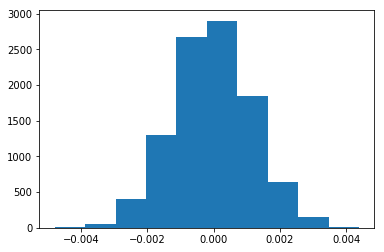

In [64]:
plt.hist(p_diffs);

j.  **p_diffs**列表的数值中，有多少比例的数值会大于 **ab_data.csv** 中观察到的实际**转化率差异** ？

In [65]:
(p_diffs > (q2-q1)).mean()

0.90239999999999998

k. 用文字解释一下你刚才在 **j.** 中计算出来的结果。在数据研究中，这个值是什么？ 根据这个数值，请判断新旧页面的转化率是否有显著差异。

**在这里给出你的答案。**


l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。使用内置程序可能很容易就能取得结果，但上面的内容仍然很重要，它可以训练你具有正确的数据统计思维。填写下面的内容来计算每个页面的转化次数，以及收到每个页面的用户数。计算新旧页面出现的次数，也就是数据中 `n_old` 与 `n_new` 分别出现的行数。

In [66]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = (df2['landing_page'] == "old_page").sum()
n_new = (df2['landing_page'] == "new_page").sum()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. 现在使用 `stats.proportions_ztest` 来计算你的 z-score 与 p-value。

In [68]:
z_score,p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative = 'smaller')
z_score,p_value

(1.3109241984234394, 0.90505831275902449)

n. 根据上题算出的 z-score 和 p-value，你认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 问题中的结果一致吗？

**在这里给出你的答案。**

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

**在这里给出你的答案。**

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [69]:
df2['intercept'] = 1
df2['ab_page'] = df2['group'].map({'treatment':1,'control':0})


c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [70]:
import statsmodels.api as sm
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [71]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 12 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        05:46:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

**在这里给出你的答案。**



f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**在这里给出你的答案。**

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。

这个国家项对转化有影响吗？提供统计输出，并书面回答这个问题。

In [74]:
df3 = pd.read_csv('countries.csv')
df4 = df2.merge(df3,on = "user_id")
df4.isnull().sum().sum()

0

In [75]:
df4[['CA','UK','US']] = pd.get_dummies(df4['country'])
log_mod2 = sm.Logit(df4['converted'],df4[['intercept','ab_page','CA','UK']])
result2 = log_mod2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 12 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        06:11:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [79]:
df4['new_page'] = df4['landing_page'].map({'new_page':1,'old_page':0})

In [80]:
df4['new_CA'] = df4['new_page'] * df4['CA']
df4['new_UK'] = df4['new_page'] * df4['UK']

In [81]:
df4['intercept'] = 1
log_mod3 = sm.Logit(df4['converted'],df4[['intercept','ab_page','new_CA','CA','new_UK','UK']])
result3 = log_mod3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 12 May 2019   Pseudo R-squ.:               3.482e-05
Time:                        06:12:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
==============================================================================
"""

<a id='conclusions'></a>
## 总结
根据以上概率，假设检验以及逻辑回归的结果显示，我们不能得出新页面的转化率高于旧页面，而根据逻辑回归中添加的新变量跟交叉项的结果显示，我们能确定各变量对转化率没有明显影响，因此需要继续延长实验时间，并且从其他变量上再次考虑影响因素。
